## Stratify Data

Problem: Labels sind imbalanced, wenn ich einfach k Klassen sample, dann kann es sein dass diese unterschiedlich viele beispiele pro klasse beinhalten und deswegen die Klassifikation mal besser und mal schlechter funktioniert. 

1. Möglichkeit: wiederhole das samplen der k Klassen für r random seeds und mittele die Ergebnisse. 
2. Möglichkeit: stratifiziere daten von anfang an, setze einen Schwellwert von z.B. 100 samples fest und werfe alle Klassen weg die weniger als 100 samples haben.  

- Tradeoff zwischen mehr few shot examples und steigender kontextlänge. Plot: wie steigt die kontextlänge gegeben der samples. Wie verändert sich die performance gegeben der kontextlänge auf x achse bzw. samples auf x achse
- Experiment: kontextlänge einsparen durch 
    - abkürzungen 
    - sonderzeichen weglassen
    - vorheriges paraphrasieren um zu kürzen (macht das sinn?)
    - dynamisches erstellen des promptes durch vorheriges RAG, es werden nur die 5 zutreffendsten klassen genommen und dazu dann gleiche anzahl an few shot examples vs. höhere anzahl an few shot examples aber gleiche gesamtkontextlänge (vorausgesetzt man hat genügend daten)

In [2]:
import sys
sys.path.append('..')
from src.llm_alex import Llama

import numpy
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import os


/Users/alexrothmaier/Documents/llm_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/alexrothmaier/Documents/llm_classification/venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
dataset = load_dataset("PolyAI/banking77")
train_data = dataset["train"]
test_data = dataset["test"]

#save data to a file

if not os.path.exists("../data"):
    os.makedirs("../data")
train_data.to_csv("../data/train_data.csv")
test_data.to_csv("../data/test_data.csv")

train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

Creating CSV from Arrow format: 100%|██████████| 4/4 [00:00<00:00, 412.33ba/s]


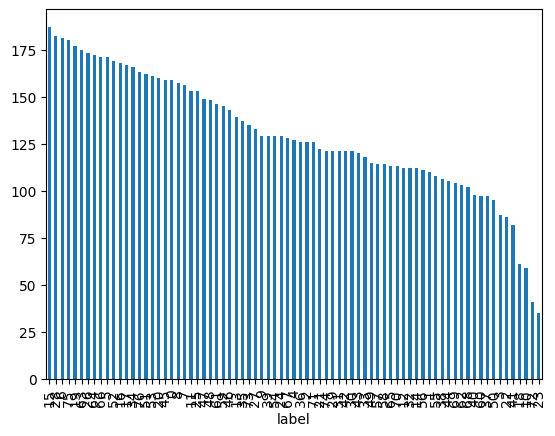

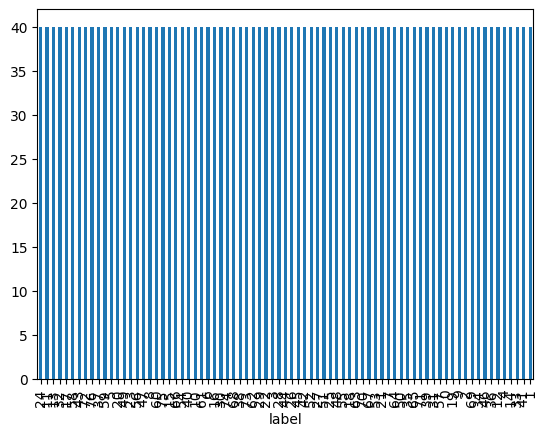

77
77


In [4]:
# check label distribution
train_data.label.value_counts().plot(kind='bar')
plt.show()

test_data.label.value_counts().plot(kind='bar')
plt.show()

print(len(train_data.label.unique()))  
print(len(test_data.label.unique()))

/var/folders/m6/4_p41bcx58jddx_zhmmqd_v00000gn/T/ipykernel_75653/881254091.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))


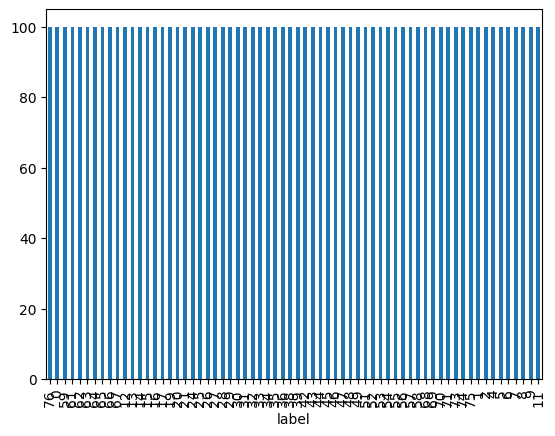

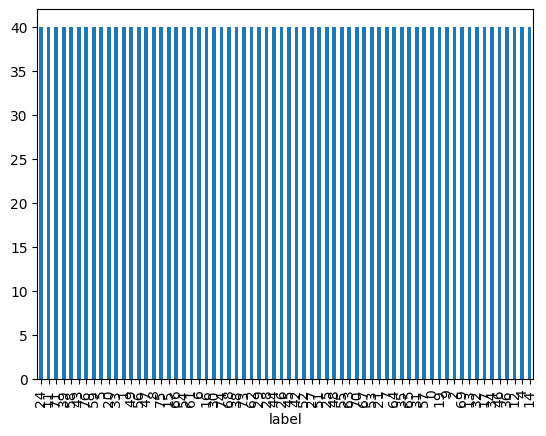

removed 11 classes


In [5]:
# stratify the data to 100 samples per class and remove classes with less than 100 samples
label_counts = train_data['label'].value_counts()
filtered_labels = label_counts[label_counts >= 100].index
train_data = train_data[train_data['label'].isin(filtered_labels)]
train_data = train_data.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))

#reflect the changes in the test data
test_data = test_data[test_data['label'].isin(filtered_labels)]

train_data.label.value_counts().plot(kind='bar')
plt.show()

test_data.label.value_counts().plot(kind='bar')
plt.show()

print(f"removed {len(label_counts) - len(filtered_labels)} classes")


In [6]:
#generate few shot prompt 
random_seed = 42
n_classes = 5
num_shots = 2

prompt = """Your task is to classify a given text into one of the following classes: 



"""
# sample n_classes with random seed
sampled_classes = train_data['label'].sample(n_classes, random_state=random_seed).values
train_data_sub = train_data[train_data['label'].isin(sampled_classes)]
test_data_sub = test_data[test_data['label'].isin(sampled_classes)]

def get_prompt_template(train_data_sub, num_shots):
    prompt_template = "Your task is to classify a given text into one of the following classes: \n\n"
    for label in train_data_sub.label.unique():
        prompt_template += f"Label: {label}\n"
        for i, row in train_data_sub[train_data_sub['label'] == label].sample(num_shots, random_state=random_seed).iterrows():
            prompt_template += f"Text: {row['text']}\n"
            #remove row from the dataframe
            train_data_sub = train_data_sub.drop(i)
        prompt_template += "\n"
    prompt_template += "Here is your text, please classify it into one of the above classes\n\n"
    return prompt_template




In [7]:
print(get_prompt_template(train_data_sub, num_shots))
print(f"Length of the prompt template: {len(get_prompt_template(train_data_sub, num_shots))} characters")

Your task is to classify a given text into one of the following classes: 

Label: 7
Text: What is preventing me from adding a specific beneficiary?
Text: why is a transfer to beneficiary not possible?

Label: 19
Text: It seems I've suddenly been charged for my recent ATM cash withdrawal. What's up with that? I though withdrawals are free, you never charged me so far!
Text: I used my card to get cash then I was charged a fee that I shouldn't have been charged.

Label: 33
Text: Does the app allowing exchanges between USD and GBP
Text: Is it possible to exchange currencies on the app?

Label: 51
Text: Why isn't a refund showing on my statement?
Text: Can I check my recent refund in my statement?

Label: 64
Text: I am confused about your fee structure and was disappointed to see a fee for my transfer.
Text: why was i chargged

Here is your text, please classify it into one of the above classes


Length of the prompt template: 904 characters


In [14]:
!pip install wandb

     |████████████████████████████████| 6.7 MB 1.9 MB/s eta 0:00:01
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached setproctitle-1.3.3-cp310-cp310-macosx_10_9_x86_64.whl (11 kB)
     |████████████████████████████████| 289 kB 12.2 MB/s eta 0:00:01
  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
     |████████████████████████████████| 412 kB 10.6 MB/s eta 0:00:01
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.1-py3-none-any.whl (24 kB)
You should consider upgrading via the '/Users/alexrothmaier/Documents/llm_classification/venv/bin/python3 -m pip install --upgrade pip' command.


In [40]:
#iterate over the test data and generate the prompt
#surpress warnings
import warnings

warnings.filterwarnings("ignore")

prompt_template = get_prompt_template(test_data_sub, num_shots)

n_classes_list = [5, 10, 20, 30, 40, 50, 77]
num_shots = 5
results = {}
#iterate over the n_classes_list

# import wandb 
# wandb.init(project="llm-banking77")

from sklearn.metrics import classification_report

for n_classes in n_classes_list:
    sampled_classes = train_data['label'].sample(n_classes, random_state=random_seed).values
    train_data_sub = train_data[train_data['label'].isin(sampled_classes)]
    test_data_sub = test_data[test_data['label'].isin(sampled_classes)]
    prompt_template = get_prompt_template(train_data_sub, num_shots)

    for i, row in test_data_sub.iterrows():
        prompt = prompt_template + f"Text: {row['text']}\n"
        # print(f"Prompt: {prompt}")
        # print("\n\n")
        #get response from the model
        response = "10"
        #print(f"Response: {response}")
        #save response to row in df
        test_data_sub.loc[i, 'response'] = response
    test_data_sub['response'] = test_data_sub['response'].astype(int)
    report = classification_report(test_data_sub['label'], test_data_sub['response'], output_dict=True)
    # #print(f"Classification Report: {classification_report}")
    # #save results to dictionary
    # results[n_classes] = {}


    results[n_classes] = {
        'classification_report': report,
        'prompt_template': prompt_template,
        'context_length': len(prompt_template)
    }
    
 

In [39]:
#save results to a file
import json
with open("../data/results.json", "w") as f:
    json.dump(results, f)
    

{5: {'classification_report': {'7': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 40.0},
   '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
   '19': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
   '33': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
   '51': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
   '64': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
   'accuracy': 0.0,
   'macro avg': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 200.0},
   'weighted avg': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 200.0}},
  'prompt_template': "Your task is to classify a given text into one of the following classes: \n\nLabel: 7\nText: What is preventing me from adding a specific beneficiary?\nText: why is a transfer to beneficiary not possible?\nText: i tried to transfer cryptocurrency into 

In [37]:
# Assuming n_classes is your list of values
n_classes = [10, 20, 30, 40]  # Example list of values

# Create an empty dictionary to store the results
results = {}

# Iterate over each value in n_classes
for num_classes in n_classes:
    # Perform your computations or operations here
    # For demonstration, let's just store a placeholder value
    # You would replace this with your actual computation
    result_value = f"Result for {num_classes} classes"

    # Save the result for the current iteration with n_classes as the key
    results[5]['x'] = result_value

# Display the results dictionary
print(results)


KeyError: 5

In [20]:
classification_report.keys()

dict_keys(['7', '10', '19', '33', '51', '64', 'accuracy', 'macro avg', 'weighted avg'])

In [21]:
classification_report

{'7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
 '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '19': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
 '33': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
 '51': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
 '64': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 40.0},
 'accuracy': 0.0,
 'macro avg': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 200.0},
 'weighted avg': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 200.0}}

In [ ]:
#change the column response to be of type int 
test_data_sub['response'] = test_data_sub['response'].astype(int)
#evaluate the model
from sklearn.metrics import classification_report
print(classification_report(test_data_sub['label'], test_data_sub['response']))


In [ ]:
llm(prompt="test",pad_token_id=)